# Aerial Cactus Prediction using fast.ai & ResNet-34
# Introduction
> To assess the impact of climate change on Earth's flora and fauna, it is vital to quantify how human activities such as logging, mining, and agriculture are impacting our protected natural areas. Researchers in Mexico have created the [VIGIA project](https://jivg.org/research-projects/vigia/), which aims to build a system for autonomous surveillance of protected areas. A first step in such an effort is the ability to recognize the vegetation inside the protected areas. In this competition, you are tasked with creation of an algorithm that can identify a specific type of cactus in aerial imagery.
>
> The original version of this data can be found [here](https://www.kaggle.com/irvingvasquez/cactus-aerial-photos), with full details in López-Jiménez's master thesis:
>
>Efren López-Jiménez, Sistema embebido para la supervisión inteligente de terrenos con vehı́culos aéreos no tripulados. Master Thesis, Instituto Politécnico Nacional, 2018. DOI: 10.13140/RG.2.2.19455.46246.

In this kernel I will attempt to identify a specific type of cactus in aerial imagery using [fast.ai](https://www.fast.ai/) and a ImageNet pre-trained ResNet-34. I will explain my process throughout the kernel, which should allow anyone familiar with the fast.ai library to follow along.

Why train a smaller model and not a larger model such as DenseNet-161? While I could train a DenseNet-161 model using the fast.ai defaults and match the top results in this competition, a smaller model that can match the accuracy of a larger model is more flexible. It could more easily be deployed as part of a smartphone app, for example. Plus training a smaller model requires different approaches and hyperparameter tuning.

In [1]:
from fastai.utils import *
from fastai.vision import *
from fastai.callbacks import *
from pathlib import Path
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import PIL
from torch.utils import model_zoo

%matplotlib inline

In [2]:
# from https://www.kaggle.com/bminixhofer/deterministic-neural-networks-using-pytorch#437938
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [3]:
# Load the pretrained weights work without needing to find the expected filename
Path('models').mkdir(exist_ok=True)
!cp '../input/resnet34/resnet34.pth' 'models/'
def load_url(*args, **kwargs):
    model_dir = Path('models')
    filename  = 'resnet34.pth'
    if not (model_dir/filename).is_file(): raise FileNotFoundError
    return torch.load(model_dir/filename)
model_zoo.load_url = load_url

After loading all the libraries, setting seeds for better reproducibility when the kernel is submitted, and pointing the fast.ai learner to the pretrained ResNet-34 weights, the data can be loaded.

In [4]:
data_path = Path("../input/aerial-cactus-identification")
train_df = pd.read_csv(data_path/'train.csv')
test_df = pd.read_csv(data_path/'sample_submission.csv')

# Data Exploration
First, I want to check balance of the dataset between cacti and non-cacti. The plot below shows a disparity between the two classes, however after some quick experimentation it was apparent that this did not cause an issue with training or predictions. This Kernel had a [area under the ROC curve](http://en.wikipedia.org/wiki/Receiver_operating_characteristic) (AUROC) of 0.9999 using ResNet-50 without accounting for the class imbalance. But to score higher with a ResNet-34 model, it will probably need to be addressed.

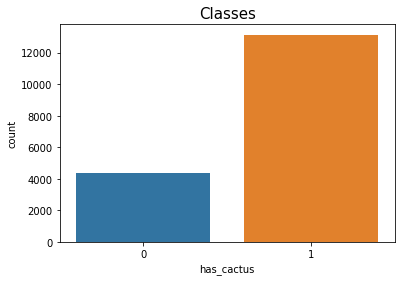

In [5]:
sns.countplot('has_cactus', data=train_df)
plt.title('Classes', fontsize=15)
plt.show()

As seen below, the cactus images are small, only 32x32 pixels. Because there is not a lot of information to work with, I don't anticipate that the fast.ai warping and rotational transformations will be that useful on the original images.

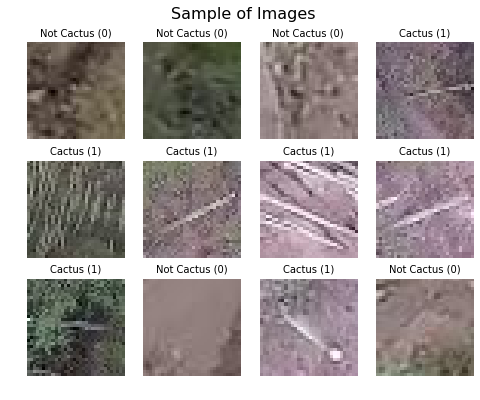

In [6]:
plt.figure(figsize=(8,6))

i = 0
sample = train_df.sample(12)
for row in sample.iterrows():
    img_name = row[1][0]
    img = PIL.Image.open(data_path/'train'/'train'/img_name)
    i += 1
    plt.subplot(3,4,i)
    title = 'Not Cactus (0)'
    if row[1][1] == 1:
        title = 'Cactus (1)'
    plt.title(title, fontsize=10)
    plt.imshow(img)
    plt.axis('off')

plt.subplots_adjust(top=0.90)
plt.suptitle('Sample of Images', fontsize=16)
plt.show()

# Oversampling

As I mentioned earlier, this Kernel scored 0.9999 AUROC leaving the class imbalance alone with ResNet-50. To see if ResNet-34 can match that score or hit 1.000 AUROC, I will correct the class imbalance by oversampling the non-cactus images. Assuming the non-cactus images are a good representation of the images seen in the wild, each image appearing three times in the dataset should not cause any issues during training thanks to the powerful transformations built into fast.ai. 

In [7]:
df1 = train_df[train_df.has_cactus==0].copy()
df2 = df1.copy()
train_df = train_df.append([df1, df2], ignore_index=True)

A quick plot verifies that the dataset is now very close to being balanced.

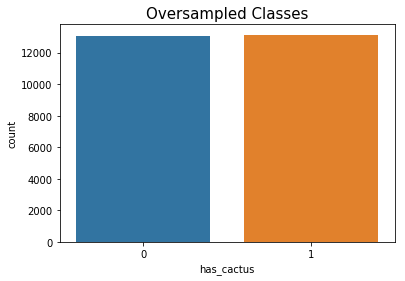

In [8]:
sns.countplot('has_cactus', data=train_df)
plt.title('Oversampled Classes', fontsize=15)
plt.show()

# Data Augmentation
Fast.ai has a powerful set of transformations [built into the library](https://docs.fast.ai/vision.transform.html). The has default setting which have experimentation been shown to be a good starting point for regular photos. These default augmentations include flipping on the horizontal axis, rotating, zooming, changing the lighting, and warping and are applied randomly on each photo during a training epoch.

Since this kernel uses aerial images, I enable flipping on the vertical axis by setting `flip_vert=True`. A trick I picked up from looking at some of the other fast.ai kernels (like this one by [Alexander Milekhin](https://www.kaggle.com/kenseitrg/simple-fastai-exercise)) is to upscale the original 32x32 images to 128x128, so the images are large enough for the fast.ai rotation, zooming, and warping transformations to be useful.

In [9]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=20, max_lighting=0.3, max_warp=0.2, max_zoom=1.2)

I then use the [data block api](https://docs.fast.ai/data_block.html) to finish constructing the dataset, holding back 20 percent of the training images as a validation set, labeling the images from the `train_df` dataframe, and adding the test images for ease of use later.

In [10]:
test_images = ImageList.from_df(test_df, path=data_path/'test', folder='test')

src = (ImageList.from_df(train_df, path=data_path/'train', folder='train')
       .split_by_rand_pct(0.2)
       .label_from_df()
       .add_test(test_images))

When performing 1cycle learning, its recommended to use a large batch size. However, for this dataset using large batch sizes of 1024 or 2048 performed worse than smaller batch sizes. After some experimentation, I concluded that a batch size of 256 works well for training the model. 

When applying transformations that changes the image size, such as perspective warping, the best performing method of dealing with squaring the now warped image is to reflect the image data to fill the edges. There is a bug in the underlying pytorch reflection method which prevents it from being used on all datasets but given the regularity of these images reflection works fine.

Since I am using transfer learning via a ResNet-34 trained on ImageNet, I need to normalize the Aerial Cactus images with `imagenet_stats` to match the pre-trained model.

In [11]:
data = (src.transform(tfms, 
                     size=128,
                     resize_method=ResizeMethod.PAD, 
                     padding_mode='reflection')
        .databunch(bs=256)
        .normalize(imagenet_stats))

A quick sanity check shows that both classes have loaded correctly.

In [12]:
data.classes, data.c

([0, 1], 2)

Plotting `show_batch` gives a visual example of the images with the data augmentation from the fast.ai transformer applied.

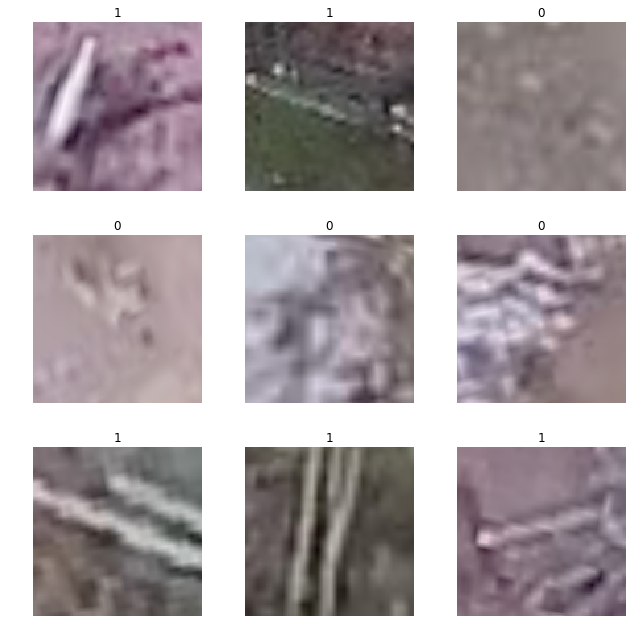

In [13]:
data.show_batch(rows=3, figsize=(9,9))

# Training the Model
Behind the scenes, the fast.ai `cnn_learner` has stripped out the last few layers of the ResNet-34 and replaced them with a few untrained layers which ends in a linear layer to predict the two classes. The pretrained ResNet-34 model is frozen and is not allowed to change while the newly created layers will be trained to predict cactus or not cactus. After training the new layers, the pretrained ResNet-34 layers can be unfrozen and the whole model trained on the dataset.

The `cnn_learner` has sensible defaults for hyperparameters such as dropout, weight decay, and momentum. After some experimentation I concluded that the fast.ai defaults perform pretty well on this dataset and have left them be.

Since this kernel is being evaluated on the [area under the ROC curve](http://en.wikipedia.org/wiki/Receiver_operating_characteristic) (AUROC) between the predicted probabilities and the observed targets, I will include `AUROC` as a metric which the learner will output while training.

In [14]:
learn = cnn_learner(data,
                    models.resnet34, 
                    metrics=[accuracy, AUROC()], 
                    path = '.')

The learning rate hyperparameter is one of the most important hyperparameters to set, and the `lr_find` method provides a graphical way to set a good learning rate. After plotting the losses, one looks for the steepest slope where the loss is decreasing the fastest. There are multiple selections that could be made, and I have chosen the steepest looking slope right before the incline decreases at 1e-3.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-03


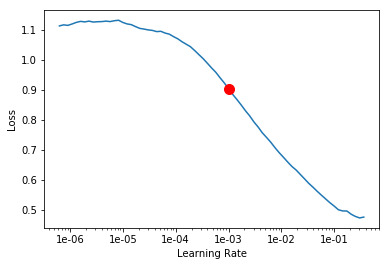

In [15]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

I will train the frozen layers of the model using `fit_one_cycle` for five epochs.

In [16]:
lr = 1e-3
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.312131,0.068657,0.974833,0.996821,01:08
1,0.103647,0.026052,0.991992,0.999396,01:05
2,0.048376,0.013408,0.996187,0.999860,01:03
3,0.027870,0.012165,0.995615,0.999906,01:07
4,0.022623,0.012194,0.995615,0.999912,01:08


The learner has a built in method for plotting the training and validation loss.

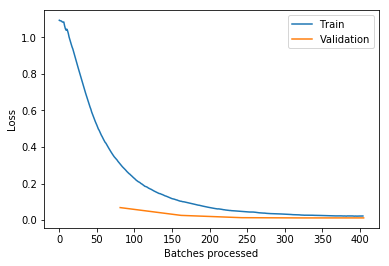

In [17]:
learn.recorder.plot_losses()

## A Digression on Fit One Cycle
`fit_one-cycle` works by taking the learning rate, dividing it by ten, and then gradually increasing and then decreasing the learning rate as training progresses. A simplified version of the idea behind 1cycle learning is increasing the learning rate allows the model to escape any suboptimal local minima. Then decreasing the learning rate assists the model in selecting a good minimum. The momentum of the model is adjusted in the opposite direction so the model does not overshoot while at the highest learning rate, but still has enough momentum to find a new minima at the lower learning rates.

The charts below show the cyclical learning rate and momentum during the training of the frozen ResNet-34 model. 

For more details on 1cycle learning, check out [Sylvain Gugger's post](https://sgugger.github.io/the-1cycle-policy.html) on the subject.

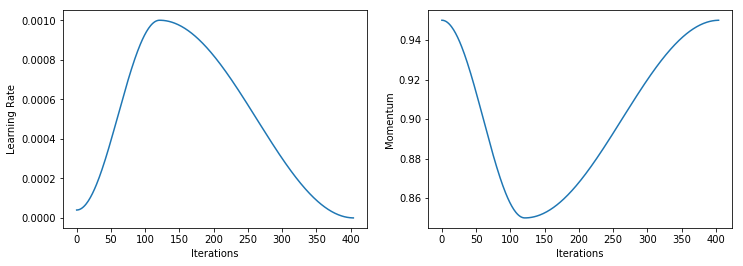

In [18]:
learn.recorder.plot_lr(show_moms=True)

## Training the Unfrozen Model
For many tasks, the output of the ResNet-34 model after five epochs would be satisfactory. But should the initial training not result in such highly accurate model, you can unfreeze the frozen layers using the `unfreeze` method of `learner` and then run `lr_find` to select a discriminative learning rate. The learning rate will be lower for the first layers of the model and then increase for the last layers of the model. A rule of thumb for selecting a good learning rate for the whole model is to pick the higher slice to be ten times before the loss jumps and then set the lower slice to be the original learning rate divided by five or ten.

In this case, I won't be using the normal procedure and instead will be using `freeze_to(1)`. This keeps the first half of the pre-trained ResNet-34 model frozen while allowing the second half to train on this dataset. The rational is the first layers are already good at picking out lines, shapes, combinations of shapes, and objects of increasing complexity. While the second half is good at identifying the wide variety of objects in ImageNet, so training the second half on this dataset will allow the model to specialize on this competition's desert fauna. 

In [19]:
learn.save('step-1')

While the default fast.ai settings worked well for the initial frozen training, I will set the weight decay `wd` to 0.1 and a range of dropout `ps` to be 0.6 and 0.4 for the unfrozen portions of the model. For this training, the model does not steadily progress in accuracy, AUROC, or training and validation loss. I will use the `SaveModelCallback` to keep track of the best performing model as determined by validation loss and use it at the end of training.

I will create a new learner with these settings and then load the weights trained in the previous step.

In [20]:
learn = cnn_learner(data,
                    models.resnet34, 
                    metrics=[accuracy, AUROC()], 
                    callback_fns=[partial(SaveModelCallback)],
                    wd=0.1,
                    ps=[0.9, 0.6, 0.4],
                    path = '.')
learn = learn.load('step-1')

Next use `lr_find` again to to select a discriminative learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


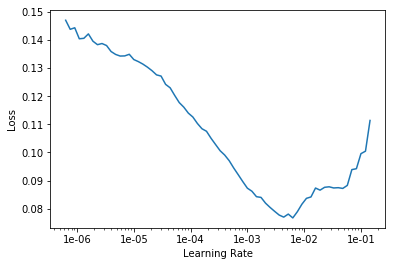

In [21]:
learn.freeze_to(1)
learn.lr_find()
learn.recorder.plot()

In this case the optimal learning rates will not differ too much: 4e-4 and 2e-4.

In [22]:
learn.fit_one_cycle(20, slice(4e-4, lr/5))

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.062315,0.008795,0.997331,0.999967,01:08
1,0.032249,0.005042,0.998284,0.999990,01:06
2,0.019130,0.003584,0.997712,0.999994,01:09
3,0.014987,0.002979,0.999047,0.999982,01:06
4,0.013610,0.003448,0.999047,0.999995,01:06
5,0.012181,0.006372,0.997140,0.999997,01:05
6,0.012528,0.002017,0.999237,0.999998,01:05
7,0.012616,0.006303,0.997903,0.999984,01:08
8,0.010870,0.001810,0.999237,0.999998,01:06
9,0.009214,0.002084,0.999237,0.999999,01:06


Better model found at epoch 0 with val_loss value: 0.008795108646154404.
Better model found at epoch 1 with val_loss value: 0.005042026750743389.
Better model found at epoch 2 with val_loss value: 0.0035843721125274897.
Better model found at epoch 3 with val_loss value: 0.0029786897357553244.
Better model found at epoch 6 with val_loss value: 0.002016589045524597.
Better model found at epoch 8 with val_loss value: 0.0018103579059243202.
Better model found at epoch 11 with val_loss value: 0.0010838124435395002.
Better model found at epoch 13 with val_loss value: 0.0008161884034052491.
Better model found at epoch 15 with val_loss value: 0.0004064432578161359.
Better model found at epoch 16 with val_loss value: 0.00022747632465325296.
Better model found at epoch 18 with val_loss value: 0.0001462859072489664.


And once again plot the losses of the model.

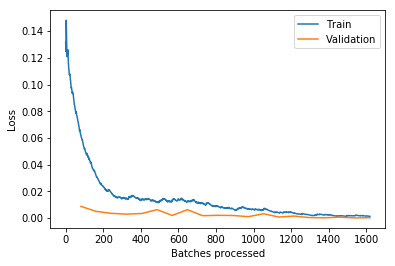

In [23]:
learn.recorder.plot_losses()

In [24]:
unfrozen_validation = learn.validate()
print("Final model validation loss: {0}".format(unfrozen_validation[0]))

Final model validation loss: 0.0001462859072489664


# Exploring the Results
After training the model on the upscaled images, it scores quite well on all metrics. Usually the model's accuracy approaches 0.999 and it's AUROC approaches 1.000 when testing against the validation set. Plotting the Confusion Matrix confirms the model's performance on the validation set. Of the roughly 5,000 images held back for validation the model misidentifies less than a few images.

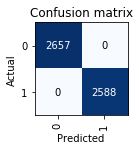

In [25]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix(figsize=(2,2))

Plotting the top losses shows the images which the fully trained ResNet-34 had the most issues with along with its prediction, loss per image, and probability it assigned to each image. It also shows a heatmap of where the model was focusing on when making its prediction.

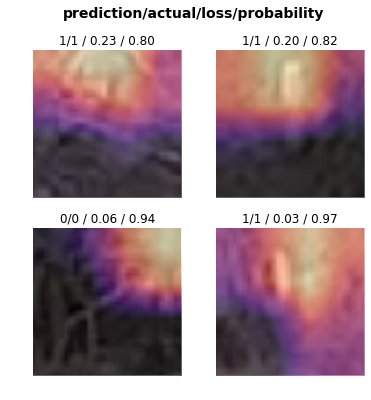

In [26]:
interp.plot_top_losses(4, figsize=(6,6))

The heatmap can be turned off for better visiual inspection of the original images.

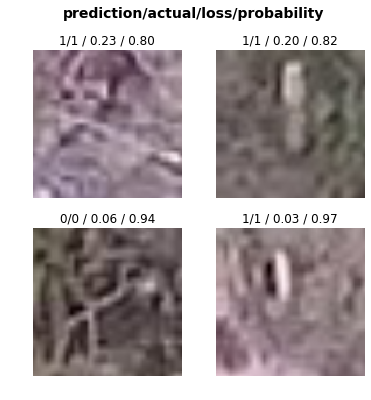

In [27]:
interp.plot_top_losses(4, figsize=(6,6), heatmap=False)

# Predictions

Now I will use the trained ResNet-34 model make predictions on the test set. The evaluation calls for the probability that each image is a cactus.

In [28]:
probability, classification = learn.get_preds(ds_type=DatasetType.Test)
test_df.has_cactus = probability.numpy()[:, 0]
test_df.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.000003
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.000003
2,001ee6d8564003107853118ab87df407.jpg,0.999998
3,002e175c3c1e060769475f52182583d0.jpg,0.999998
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.000010


And after verifying that the predictions look right, I will submit the results.

In [29]:
test_df.to_csv("submission.csv", index=False)

My previous ResNet-50 submission resulted in an AUROC of 0.9999, which is good but falls short of the top kernels' AUROC of 1.000. Will the ResNet-34 model match or beat that AUROC score? Let's submit and find out.